In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import pyzx as zx
from pyzx.circuit import Circuit, CNOT, S, XPhase, QASMParser
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [19]:
c = Circuit(3)
c.add_gate("S", 0, adjoint=False)
c.add_gate("ZPhase", 1, phase=Fraction(5,4))
c.add_gate("CNOT",0,2)
c.add_gate("TOF",0,1,2)
#c.add_gate("CCZ",0,1,2)
g = c.to_graph()
#zx.simplify.clifford_simp(g,quiet=True)
#zx.simplify.clifford_simp(g,quiet=True)
print(c.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
s q[0];
rz(5π/4) q[1];
cx q[0], q[2];
ccx q[0], q[1], q[2];



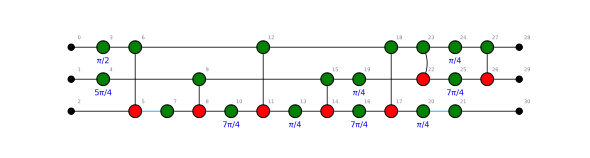

In [20]:
zx.draw(g,labels=True)

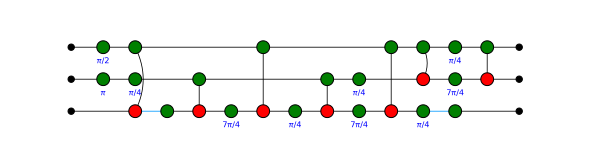

In [21]:
c2 = Circuit.from_graph(g)
zx.draw(c2.to_graph())

In [16]:
from fractions import Fraction
import math

gate = """QRot["exp(-i%Z)",-3.926990816987241e-1](0)"""
i = gate.find("exp(")
if gate[i+4:i+8] != '-i%Z':
    raise TypeError("Unsupported expression: " + gate) 
f = gate[gate.find(',')+1: gate.find(']')]
try:
    f = float(f)
except ValueError:
    raise TypeError("Unsupported expression: " + gate)
phase = Fraction(f/math.pi).limit_denominator()
target = gate[gate.rfind('(')+1:gate.rfind(')')]
try: 
    target = int(target)
except ValueError:
    raise TypeError("Unsupported expression: "+ gate)
target, phase

(0, Fraction(-1, 8))

In [11]:
import 

ValueError: could not convert string to float: 's'

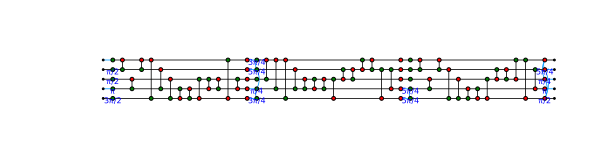

In [32]:
random.seed(1337)
g = zx.generate.cliffordT(5,70,0.15)
zx.simplify.clifford_simp(g,quiet=True)
zx.extract.circuit_extract(g)
zx.draw(g)

In [33]:
Circuit.from_graph(g).gates

[S(1),
 S(2),
 S*(4),
 HAD(3),
 Z(3),
 HAD(0),
 CNOT(0,1),
 CNOT(2,3),
 CNOT(0,1),
 CNOT(0,4),
 CNOT(1,3),
 CNOT(2,4),
 CNOT(4,3),
 CNOT(3,4),
 CNOT(4,2),
 CNOT(3,2),
 CNOT(2,3),
 CNOT(4,0),
 CNOT(3,2),
 HAD(3),
 T(3),
 HAD(4),
 Z(4),
 T*(4),
 CZ(4,3),
 HAD(0),
 Z(0),
 T*(0),
 HAD(1),
 Z(1),
 T(1),
 CZ(1,0),
 CZ(1,3),
 CNOT(0,2),
 CNOT(0,3),
 CNOT(0,4),
 CNOT(1,3),
 CNOT(2,3),
 CNOT(3,2),
 CNOT(2,3),
 CNOT(4,2),
 CNOT(2,1),
 CNOT(1,2),
 CNOT(1,0),
 CNOT(0,1),
 CNOT(4,1),
 CNOT(3,1),
 HAD(3),
 Z(3),
 T(3),
 HAD(4),
 Z(4),
 T(4),
 CZ(4,3),
 CNOT(0,1),
 CNOT(2,3),
 CNOT(0,1),
 CNOT(1,4),
 CNOT(2,4),
 CNOT(3,4),
 CNOT(4,3),
 CNOT(4,2),
 CNOT(2,1),
 CNOT(1,2),
 CNOT(2,0),
 CNOT(4,0),
 CNOT(3,1),
 XPhase(4,phase=1/2),
 XPhase(1,phase=5/4),
 CX(1,0),
 CX(1,4),
 XPhase(2,phase=1/4),
 CX(2,0),
 CX(2,4),
 NOT(3),
 HAD(1),
 HAD(2),
 HAD(3)]

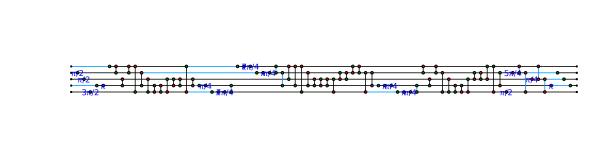

In [34]:
zx.draw(Circuit.from_graph(g).to_graph())

In [37]:
t = zx.tensor.tensorfy(g)
t2 = zx.tensor.tensorfy(Circuit.from_graph(g).to_graph())
zx.tensor.compare_tensors(t,t2)

True

[HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4), HAD(3), CCZ(c1=2,c2=4,t=3), HAD(3), HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4)]


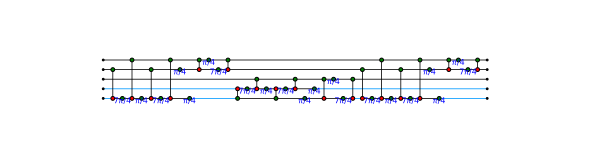

In [78]:
import os
c = Circuit.from_quipper_file(os.path.abspath("..\\circuits\\tof_3_after_light.txt"))
c = Circuit.from_quipper_file(os.path.abspath("..\\circuits\\tof_3_before.txt"))
print(c.gates)
g = c.to_graph()
zx.simplify.id_simp(g,quiet=True)
g.pack_circuit_rows()
zx.draw(g)

In [23]:
data = """// quantum ripple-carry adder
// 8-bit adder made out of 2 4-bit adders from adder.qasm
// Cuccaro et al, quant-ph/0410184
OPENQASM 2.0;
include "qelib1.inc";
gate majority a,b,c 
{ 
  cx c,b; 
  cx c,a; 
  ccx a,b,c; 
}
gate unmaj a,b,c 
{ 
  ccx a,b,c; 
  cx c,a; 
  cx a,b; 
}

// add a to b, storing result in b
gate add4 a0,a1,a2,a3,b0,b1,b2,b3,cin,cout 
{
  majority cin,b0,a0;
  majority a0,b1,a1;
  majority a1,b2,a2;
  majority a2,b3,a3;
  cx a3,cout;
  unmaj a2,b3,a3;
  unmaj a1,b2,a2;
  unmaj a0,b1,a1;
  unmaj cin,b0,a0;
}

// add two 8-bit numbers by calling the 4-bit ripple-carry adder
// carry bit on output lives in carry[0]
qreg carry[2];
qreg a[8];
qreg b[8];
creg ans[8];
creg carryout[1];
// set input states
x a[0]; // a = 00000001
x b;
x b[6]; // b = 10111111
// output should be 11000000 0

add4 a[0],a[1],a[2],a[3],b[0],b[1],b[2],b[3],carry[0],carry[1];
add4 a[4],a[5],a[6],a[7],b[4],b[5],b[6],b[7],carry[1],carry[0];

measure b[0] -> ans[0];
measure b[1] -> ans[1];
measure b[2] -> ans[2];
measure b[3] -> ans[3];
measure b[4] -> ans[4];
measure b[5] -> ans[5];
measure b[6] -> ans[6];
measure b[7] -> ans[7];
measure carry[0] -> carryout[0];"""

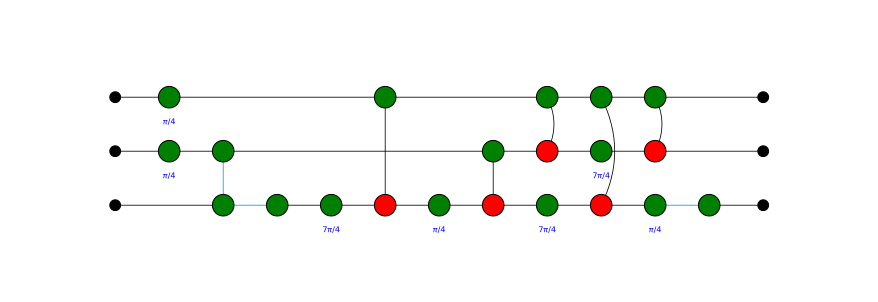

In [31]:
s = """OPENQASM 2.0;
include "qelib1.inc";

gate ccx a,b,c
{
h c;
cx b,c; tdg c;
cx a,c; t c;
cx b,c; tdg c;
cx a,c; t b; t c; h c;
cx a,b; t a; tdg b;
cx a,b;
}

qreg q[3];
ccx q[0], q[1], q[2];
"""
p = QASMParser()
c = p.parse(s)
g = c.to_graph()
zx.simplify.clifford_simp(g,quiet=True)
c2 = zx.extract.streaming_extract(g)
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c2,optimize=True)
#zx.simplify.id_simp(g,quiet=True)
zx.draw(c3.to_graph(compress_rows=True),figsize=(12,4))

id_simp
16. 11. 1. 
finished in 4 iterations


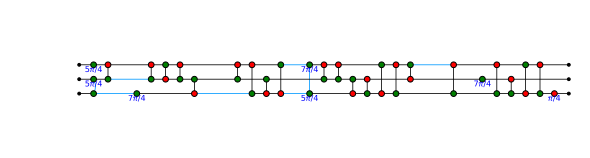

In [22]:
zx.simplify.clifford_simp(g, quiet=True)
zx.extract.circuit_extract(g)
zx.simplify.id_simp(g)
zx.draw(g)

In [53]:
r = []
for s in data.splitlines():
    if s.find("//")!=-1:
        t = s[0:s.find("//")].strip()
    else: t = s.strip()
    if t: r.append(t)
data = "\n".join(r)

In [54]:
custom_gates = []
i = 0
while True:
    i = data.find("gate ",i)
    if i == -1: break
    j = data.find("}", i)
    custom_gates.append(data[i:j+1])
    data = data[:i] + data[j+1:]

In [94]:
custom_gates

['gate majority a,b,c\n{\ncx c,b;\ncx c,a;\nccx a,b,c;\n}',
 'gate unmaj a,b,c\n{\nccx a,b,c;\ncx c,a;\ncx a,b;\n}',
 'gate add4 a0,a1,a2,a3,b0,b1,b2,b3,cin,cout\n{\nmajority cin,b0,a0;\nmajority a0,b1,a1;\nmajority a1,b2,a2;\nmajority a2,b3,a3;\ncx a3,cout;\nunmaj a2,b3,a3;\nunmaj a1,b2,a2;\nunmaj a0,b1,a1;\nunmaj cin,b0,a0;\n}']

In [93]:
commands = [s.strip() for s in data.split(";") if s.strip()][2:]
qubit_count = 0
offsets = {}
for c in commands:
    name, rest = c.split(" ",1)
    if name in ("barrier","creg","measure", "id"): continue
    args = [s.strip() for s in rest.split(",") if s.strip()]
    if name == "qreg":
        regname, size = args[0].split("[",1)
        size = int(size[:-1])
        offsets[regname] = (qubit_count, size)
        qubit_count += size
        continue
    qubit_values = []
    is_range = False
    dim = 1
    print(c)
    for a in args:
        if "[" in a:
            regname, val = a.split("[",1)
            val = int(val[:-1])
            if not regname in offsets: raise TypeError("Unvalid register {}".format(regname))
            qubit_values.append([offsets[regname][0]+val])
        else:
            if is_range:
                if offsets[regname][1] != dim:
                    raise TypeError("Error in parsing {}: Register sizes do not mach".format(c))
            else:
                dim = offsets[regname][1]
            is_range = True
            s = offsets[a][0]
            qubit_values.append(list(range(s,s + dim)))
    if is_range:
        for i in range(len(qubit_values)):
            if len(qubit_values[i]) != dim:
                qubit_values[i] = [qubit_values[i][0]]*dim
    for j in range(dim):
        argset = [q[j] for q in qubit_values]
    if name in ("x", "z", "s", "t", "h", "sdg", "tdg"):
        #g_cls = qasm_gate_table[name]
        if name in ("sdg", "tdg"): pass
offsets

x a[0]
[2]
x b
10
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
x b[6]
[16]
add4 a[0],a[1],a[2],a[3],b[0],b[1],b[2],b[3],carry[0],carry[1]
[2, 3, 4, 5, 10, 11, 12, 13, 0, 1]
add4 a[4],a[5],a[6],a[7],b[4],b[5],b[6],b[7],carry[1],carry[0]
[6, 7, 8, 9, 14, 15, 16, 17, 1, 0]


{'a': (2, 8), 'b': (10, 8), 'carry': (0, 2)}

In [15]:
data = 'gate majority(  ) a,b,c\n{\ncx c,b;\ncx c,a;\nccx a,b,c;\n}'
data = data[5:]
spec, body = data.split("{",1)
i = spec.find("(")
j = spec.find(")")
spec = spec[:i] + spec[j+1:]
spec = spec.strip()
name, args = spec.split(" ", 1)
body = body[:-1].strip()
commands = [s.strip() for s in body.split(";") if s.strip()]
commands

['cx c,b', 'cx c,a', 'ccx a,b,c']

In [13]:
import os
f = os.path.abspath("../circuits/Arithmetic_and_Toffoli/barenco_tof_5_before")
c = Circuit.from_quipper_file(f)
print(c.stats())

Circuit on 9 qubits with 26 gates.
        0 T-like gates
        14 Cliffords among which 
        0 2-qubit gates and 14 Hadamard gates.
There are 12 gates of a different type


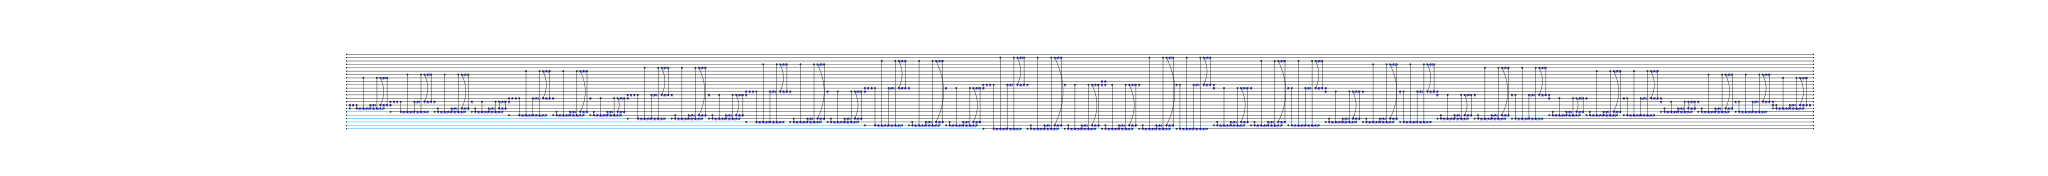

In [23]:
zx.draw(c.to_graph(),figsize=(60,5))

In [14]:
g = c.to_graph()
zx.simplify.clifford_simp(g,quiet=True)
c2 = zx.extract.streaming_extract(g)
print(len(c2.gates))
g = c2.to_graph()
zx.simplify.to_gh(g)
zx.simplify.id_simp(g,quiet=True)
c3 = zx.Circuit.from_graph(g, split_phases=False)
print(len(c3.gates))
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c3, optimize=True)
print(c3.stats())
#zx.draw(c3.to_graph(compress_rows=True),figsize=(30,6))

294
286
Circuit on 9 qubits with 176 gates.
        68 T-like gates
        108 Cliffords among which 
        78 2-qubit gates and 24 Hadamard gates.


In [56]:
from pyzx.circuit import ZPhase
isinstance(c3.gates[0],ZPhase)

True

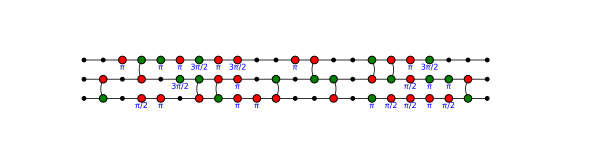

In [14]:
import os
file_name = os.path.abspath("..\\circuits\\small.qgraph")
with open(file_name, 'r') as qgraph:
    js = qgraph.read()
    g3 = zx.json_to_graph(js)
    js = zx.graph_to_json(g3)
    g3 = zx.json_to_graph(js)
zx.draw(g3)
#print(g3.depth())